In [1]:
import numpy as np
import pymc as pm
import arviz as az
import sklearn
from random import random, randint, seed
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
import matplotlib.pyplot as plt

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
pm.__version__, sklearn.__version__

('4.3.0', '1.1.3')

### Create a regression dataset with outliers

(100, 1) (100,)


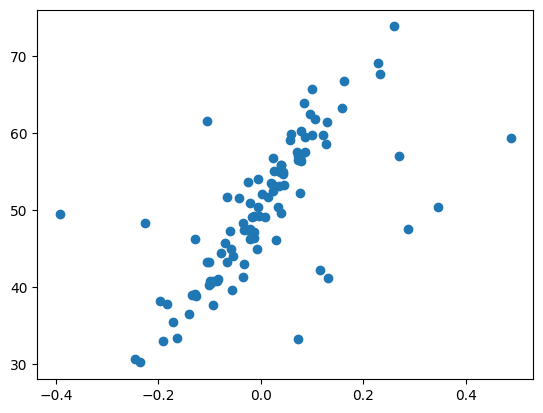

In [3]:

# prepare the dataset
def get_dataset():
    X, y = make_regression(n_samples=100, n_features=1, tail_strength=0.9, effective_rank=1, 
                           n_informative=1, noise=3, bias=50, random_state=1)
    # add some artificial outliers
    seed(1)
    for i in range(10):
        factor = randint(2, 4)
        if random() > 0.5:
            X[i] += factor * X.std()
        else:
            X[i] -= factor * X.std()
    return X, y
 
# load dataset
X, y = get_dataset()
# summarize shape
print(X.shape, y.shape)
# scatter plot of input vs output
pyplot.scatter(X, y)
pyplot.show()

### Linear Regression

In [4]:
# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return np.absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = np.arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()

Mean MAE: 5.260 (1.149)


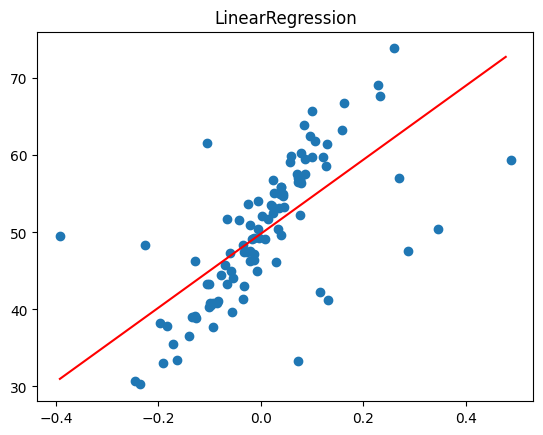

In [5]:
# define the model
model = LinearRegression()
# evaluate model
results = evaluate_model(X, y, model)
print('Mean MAE: %.3f (%.3f)' % (np.mean(results), np.std(results)))
# plot the line of best fit
plot_best_fit(X, y, model)

In [6]:
model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [7]:
vars(model)

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([48.03658059]),
 'rank_': 1,
 'singular_': array([1.28795283]),
 'intercept_': 49.83184681801059}

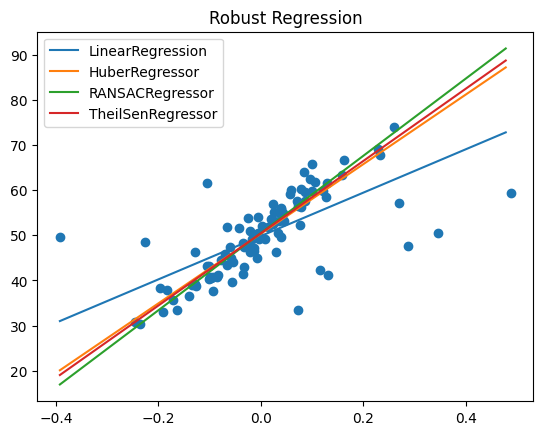

In [8]:
# plot line of best for multiple robust regression algorithms
from random import random
from random import randint
from random import seed
from numpy import arange
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from matplotlib import pyplot

# prepare the dataset
def get_dataset():
	X, y = make_regression(n_samples=100, n_features=1, tail_strength=0.9, effective_rank=1, n_informative=1, noise=3, bias=50, random_state=1)
	# add some artificial outliers
	seed(1)
	for i in range(10):
		factor = randint(2, 4)
		if random() > 0.5:
			X[i] += factor * X.std()
		else:
			X[i] -= factor * X.std()
	return X, y

# dictionary of model names and model objects
def get_models():
	models = list()
	models.append(LinearRegression())
	models.append(HuberRegressor())
	models.append(RANSACRegressor())
	models.append(TheilSenRegressor())
	return models

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, xaxis, model):
	# fit the model on all data
	model.fit(X, y)
	# calculate outputs for grid across the domain
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	# plot the line of best fit
	pyplot.plot(xaxis, yaxis, label=type(model).__name__)

# load the dataset
X, y = get_dataset()
# define a uniform grid across the input domain
xaxis = arange(X.min(), X.max(), 0.01)
for model in get_models():
	# plot the line of best fit
	plot_best_fit(X, y, xaxis, model)
# plot the dataset
pyplot.scatter(X, y)
# show the plot
pyplot.title('Robust Regression')
pyplot.legend()
pyplot.show()

### Bayesian Linear Regression
$$
y = a*x + b
$$

In [9]:
np.mean(y)

50.063037899326716

In [10]:
with pm.Model() as linear:
    a = pm.Normal("a", mu=0, sigma=10)
    b = pm.Normal("b", mu=0, sigma=10)
    error = pm.Normal("error", mu=0, sigma=10)
    nu = pm.Uniform("nu", 1, 10)
    
    y_obs = pm.StudentT("y_obs", mu=a*X.squeeze() + b, sigma=error, nu=nu, observed=y)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, error, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


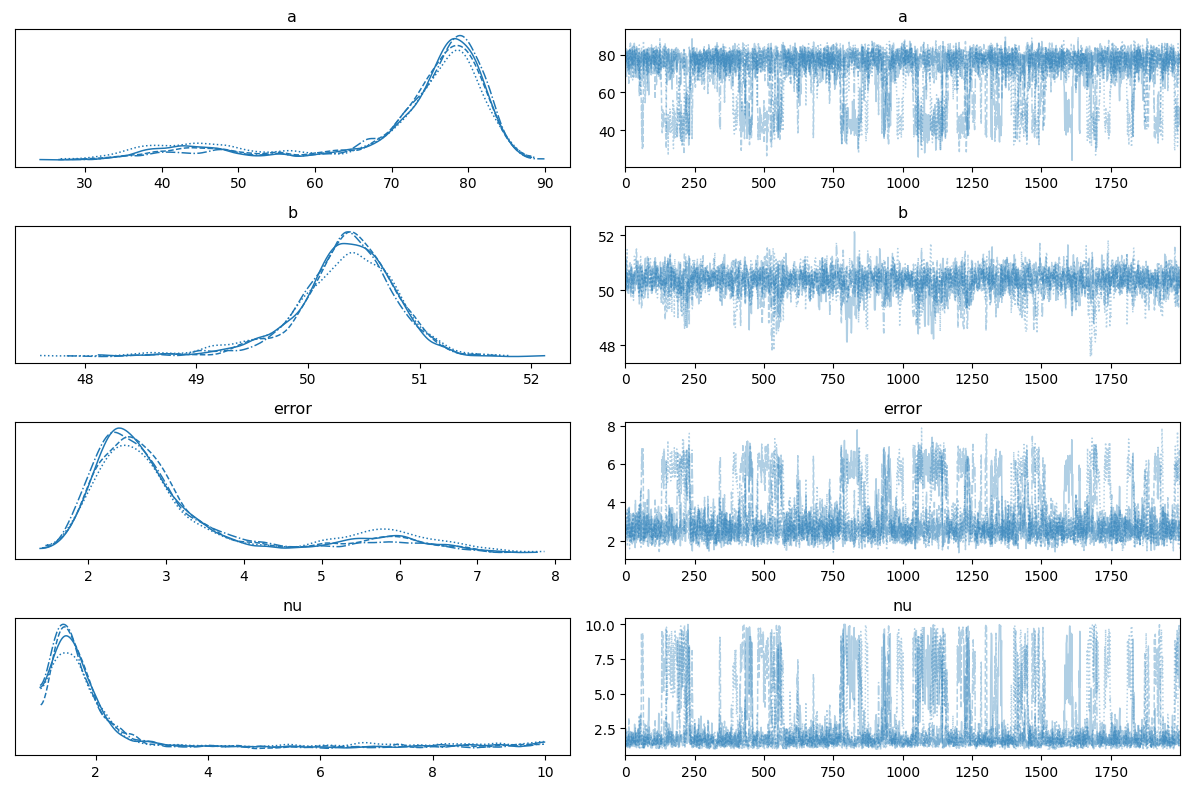

In [11]:
az.plot_trace(trace);
plt.tight_layout()

In [12]:
trace.posterior["a"].mean()

<xarray.DataArray 'a' ()>
array(71.78676484)

In [13]:
trace.posterior["b"].mean()

<xarray.DataArray 'b' ()>
array(50.32768649)

In [14]:
X.shape, y.shape

((100, 1), (100,))

In [15]:
a_ols, b_ols = np.polyfit(X.squeeze(), y, deg=1)
a_ols, b_ols

(48.036580591651486, 49.83184681801058)

In [16]:
def plot_line(a, b, **kwargs):
    plt.axline((0,b), slope=a, **kwargs)
    return ax

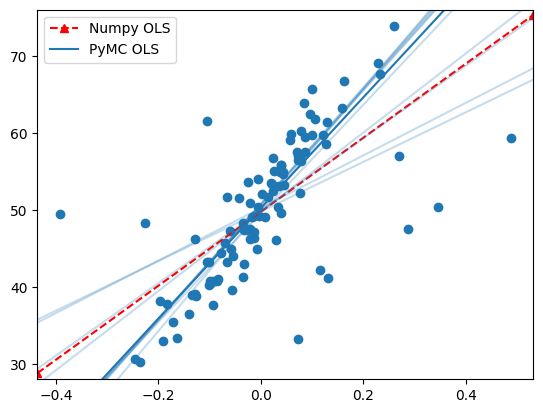

In [20]:
fig, ax = plt.subplots()
plt.scatter(X,y)
plot_line(a_ols, b_ols, c='r', ls='--', marker = '^', label="Numpy OLS")
plot_line(trace.posterior["a"].mean(), trace.posterior["b"].mean(), label="PyMC OLS")

n_lines = 200
for a_, b_ in trace.posterior[['a', 'b']].sel(chain=1).thin(n_lines).to_array().T:
    plot_line(a_, b_, alpha=0.25)
    
plt.legend()